In [1]:
import gc
import numpy as np
import pandas as pd
import os
import tensorflow as tf
os.environ['KMP_DUPLICATE_LIB_OK']='True'

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
BM_1587adj_20250411 = np.load('D:/mzh/TRD_Review_20251022/BM_1587adj_20250417.npy',allow_pickle=True)
BM_1587InFlow_15min_20250411 = np.load('D:/mzh/TRD_Review_20251022/350m/BM_1587InFlow_15min_20250411.npy',allow_pickle=True)
BM_1587InFlow_15min_6_12 = BM_1587InFlow_15min_20250411[:,5,20:20+48]
BM_1587RepairedTime_20250411 = np.load('D:/mzh/TRD_Review_20251022/BM_1587RepairedTime_20250411.npy',allow_pickle=True)
BM_1587node_20250411 = np.load('D:/mzh/TRD_Review_20251022/BM_1587node_20250411.npy',allow_pickle=True)
BM_Station_LatLon_1587 = np.load('D:/mzh/TRD_Review_20251022/350m/BM_Station_LatLon_1587.npy',allow_pickle=True)
BM_1587Edge_20250412 = np.load('D:/mzh/TRD_Review_20251022/BM_1587edge_20250417.npy',allow_pickle=True)

In [3]:
BM_1587InFlow_15min_20250616 = BM_1587InFlow_15min_20250411[:,5,:]
BM_1587InFlow_15min_20250616.shape

(1587, 96)

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371 
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    a = (np.sin(dLat/2) * np.sin(dLat/2) +
         np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) *
         np.sin(dLon/2) * np.sin(dLon/2))
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

In [5]:
random_020 = np.load(r'D:\mzh\random_020.npy',allow_pickle=True)
random_020 = random_020.tolist()

In [6]:
import numpy as np
import scipy.sparse as sp

raw_adj = BM_1587adj_20250411
adj_with_self_loops = raw_adj + np.eye(raw_adj.shape[0])
def symmetric_normalization(adj):
    degree = np.array(adj.sum(1)).flatten()
    degree_sqrt_inv = 1.0 / np.sqrt(degree)
    degree_sqrt_inv_mat = sp.diags(degree_sqrt_inv)
    norm_adj = degree_sqrt_inv_mat.dot(adj).dot(degree_sqrt_inv_mat)
    return norm_adj.astype(np.float32)
    
sparse_adj = sp.csr_matrix(adj_with_self_loops)
normalized_adj = symmetric_normalization(sparse_adj)
    
normalized_adj_dense = normalized_adj.toarray()
    
np.save("normalized_BM_adj.npy", normalized_adj_dense)


In [7]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, Model
import math
import os
import datetime
import gc
import matplotlib.pyplot as plt
import folium

# Hyperparameter Configuration
GAMMA = 0.99  
LEARNING_RATE = 0.001  
MEMORY_SIZE = 50000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_MIN = 0.05  
EPSILON_DECAY = 0.998  
TARGET_UPDATE_FREQ = 500  
L2_REG = 0.00001
PER_ALPHA = 0.6
PER_BETA = 0.4
PER_BETA_INCREMENT = 0.001
PER_EPSILON = 1e-6
HER_RATIO = 0.4
PARAM_NOISE_STDDEV = 0.1
NOISE_ADAPTATION_RATE = 0.01
TARGET_PERTURBATION = 0.05
MAX_DISPLACEMENT = 3.0  
DISTANCE_PENALTY = 10.0  
PER_BETA_START = 0.4
PER_BETA_FRAMES = 10000

class DynamicAdjGenerator(layers.Layer):
    def __init__(self, static_adj, num_nodes, window_size=6, **kwargs):
        super().__init__(**kwargs)
        self.static_adj = tf.constant(static_adj, dtype=tf.float32)
        self.num_nodes = num_nodes
        self.window = window_size
        
        self.temporal_net = tf.keras.Sequential([
            layers.Conv1D(12, 3, activation='elu', padding="same"),
            layers.Conv1D(2, 3, activation='elu', padding="same"),
            layers.Dropout(0.05),
            layers.Flatten(),
            layers.LayerNormalization(),
            layers.Dense(12, activation='elu'),
        ])
        
        self.dense_1 = layers.Dense(num_nodes, activation='elu')
        self.dense_2 = layers.Dense(num_nodes, activation='elu')
        
    def call(self, x):
        window_data = x[:, -self.window:]
        temporal_weights = self.temporal_net(tf.transpose(window_data, [0,2,1,3]))
        
        denweight_1 = tf.expand_dims(self.dense_1(temporal_weights), axis=1)
        denweight_2 = tf.expand_dims(self.dense_2(temporal_weights), axis=2)
        temporal_weights = denweight_1 + denweight_2
        temporal_weights = tf.reshape(temporal_weights, [-1, self.num_nodes, self.num_nodes])
        
        dyn_adj = self.static_adj * tf.nn.sigmoid(temporal_weights)
        return dyn_adj
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "static_adj": self.static_adj.numpy(),
            "num_nodes": self.num_nodes,
            "window_size": self.window
        })
        return config

class DynamicGCNLayer(layers.Layer):
    def __init__(self, output_dim, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, input_shape):
        self.w1 = self.add_weight(shape=(input_shape[-1], self.output_dim),
                                 initializer='glorot_uniform',
                                 name='gcn_weight1')
        self.w2 = self.add_weight(shape=(input_shape[-1], self.output_dim),
                                 initializer='glorot_uniform',
                                 name='gcn_weight2')
        super().build(input_shape)
        
    def call(self, inputs, adjacency):
        adj = tf.repeat(adjacency, tf.shape(inputs)[0]//tf.shape(adjacency)[0], axis=0)
        
        h1 = tf.matmul(inputs, self.w1)
        output1 = tf.einsum('bij,bjk->bik', adj, h1)
        
        h2 = tf.matmul(inputs, self.w2)
        output2 = tf.einsum('bij,bjk->bik', adj, h2)
        
        output = tf.concat([output1, output2], axis=-1)
        return self.activation(output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "activation": tf.keras.activations.serialize(self.activation)
        })
        return config

In [8]:
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = [None] * capacity
        self.write = 0
        self.size = 0
        self.max_priority = 1.0

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, priority, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)
        self.write = (self.write + 1) % self.capacity
        if self.size < self.capacity:
            self.size += 1
        if priority > self.max_priority:
            self.max_priority = priority

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        self._propagate(idx, change)
        if priority > self.max_priority:
            self.max_priority = priority

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1
        return idx, self.tree[idx], self.data[data_idx]

class PriorityReplayBuffer:
    def __init__(self, capacity, alpha):
        self.capacity = capacity
        self.alpha = alpha
        self.beta = PER_BETA_START
        self.tree = SumTree(capacity)
        self.size = 0
        self.max_priority = 1.0

    def add(self, experience):
        priority = self.max_priority ** self.alpha
        self.tree.add(priority, experience)
        self.size = self.tree.size

    def sample(self, batch_size, beta):
        if self.size == 0:
            return [], [], []
            
        samples = []
        indices = []
        priorities = []
        
        segment = self.tree.total() / batch_size
        
        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = np.random.uniform(a, b)
            idx, priority, data = self.tree.get(s)
            samples.append(data)
            indices.append(idx)
            priorities.append(priority)
        
        sampling_probabilities = np.array(priorities) / self.tree.total()
        weights = (self.size * sampling_probabilities) ** (-beta)
        weights /= weights.max()
        
        return samples, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            adjusted_priority = (priority + PER_EPSILON) ** self.alpha
            self.tree.update(idx, adjusted_priority)
            if adjusted_priority > self.max_priority:
                self.max_priority = adjusted_priority

In [9]:
class NoisyDense(layers.Layer):
    def __init__(self, units, sigma_init=0.5, activation=None, **kwargs):
        super(NoisyDense, self).__init__(**kwargs)
        self.units = units
        self.sigma_init = sigma_init
        self.activation = tf.keras.activations.get(activation)
        
    def build(self, input_shape):
        self.input_dim = input_shape[-1]
        self.w_mu = self.add_weight(
            name='w_mu',
            shape=(self.input_dim, self.units),
            initializer='glorot_uniform',
            trainable=True
        )
        self.w_sigma = self.add_weight(
            name='w_sigma',
            shape=(self.input_dim, self.units),
            initializer=tf.keras.initializers.Constant(self.sigma_init),
            trainable=True
        )
        self.w_epsilon = self.add_weight(
            name='w_epsilon',
            shape=(self.input_dim, self.units),
            initializer='zeros',
            trainable=False
        )
        self.b_mu = self.add_weight(
            name='b_mu',
            shape=(self.units,),
            initializer='zeros',
            trainable=True
        )
        self.b_sigma = self.add_weight(
            name='b_sigma',
            shape=(self.units,),
            initializer=tf.keras.initializers.Constant(self.sigma_init),
            trainable=True
        )
        self.b_epsilon = self.add_weight(
            name='b_epsilon',
            shape=(self.units,),
            initializer='zeros',
            trainable=False
        )
        self.reset_noise()
        
    def call(self, inputs):
        w_noisy = self.w_mu + self.w_sigma * self.w_epsilon
        b_noisy = self.b_mu + self.b_sigma * self.b_epsilon
        output = tf.matmul(inputs, w_noisy) + b_noisy
        return self.activation(output)
    
    def reset_noise(self):
        w_epsilon = tf.random.normal(shape=(self.input_dim, self.units), mean=0.0, stddev=1.0)
        b_epsilon = tf.random.normal(shape=(self.units,), mean=0.0, stddev=1.0)
        self.w_epsilon.assign(w_epsilon)
        self.b_epsilon.assign(b_epsilon)
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units,
            "sigma_init": self.sigma_init,
            "activation": tf.keras.activations.serialize(self.activation)
        })
        return config

In [10]:
class DoubleDQNAgent:
    def __init__(self, state_shape, action_size, damaged_sites, adj_matrix, BM_Edge, station_positions):
        self.damaged_sites = damaged_sites
        self.state_shape = state_shape
        self.action_size = action_size
        self.memory = PriorityReplayBuffer(MEMORY_SIZE, PER_ALPHA)
        self.epsilon = EPSILON_START
        self.global_step = 0
        self.beta = PER_BETA_START
        self.BM_Edge = BM_Edge
        self.station_positions = station_positions
        
        if tf.is_tensor(adj_matrix):
            adj_matrix = adj_matrix.numpy()
        self.adj_matrix = adj_matrix
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target()
        self.last_loss = 0.0
        self.current_position = None
        self.repair_route = []  
        
    def _build_model(self):
        inputs = layers.Input(shape=(self.state_shape[0], self.state_shape[1]))
        
        # Status
        inputs_status = inputs[:,:,:5]
        x_1 = layers.Dense(64, activation='elu')(inputs_status)
        x_1 = layers.Dense(1, activation='elu')(x_1)
        x_Status = layers.Flatten()(x_1)
        x_Status = layers.Dense(64, activation='elu')(x_Status)
        
        # Time
        inputs_time = inputs[:,:,5:]
        x = tf.expand_dims(inputs_time, axis=1)
        
        # 动态邻接矩阵
        dyn_adj = DynamicAdjGenerator(
            static_adj=self.adj_matrix,
            num_nodes=self.state_shape[0],
            window_size=4
        )(x)
        
        x = tf.squeeze(x, axis=1)
        x = DynamicGCNLayer(32, activation='swish')(x, dyn_adj)
        x = layers.TimeDistributed(layers.Dense(64, activation='swish'))(x)

        damaged_indices = tf.constant(self.damaged_sites, dtype=tf.int32)
        x_damaged = tf.gather(x, damaged_indices, axis=1)
        x_time = layers.GlobalMaxPooling1D()(x_damaged)
        
        x = layers.Concatenate()([x_Status, x_time])
        
        value = NoisyDense(128, activation='elu', name='noisy_value_1')(x)
        value = NoisyDense(1, name='noisy_value_out')(value)
        
        advantage = NoisyDense(128, activation='elu', name='noisy_advantage_1')(x)
        advantage = NoisyDense(self.action_size, name='noisy_advantage_out')(advantage)
        
        q_values = value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))
        
        model = Model(inputs=inputs, outputs=q_values)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(LEARNING_RATE, clipnorm=1.0),
            loss=tf.keras.losses.Huber()
        )
        return model
    
    def update_target(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def get_action(self, state):
        q_values = self.model.predict(state[np.newaxis], verbose=0)[0]
        mask = np.zeros(self.action_size, dtype=float)
        
        for i, site in enumerate(self.damaged_sites):
            if state[site, 3] == 0 and state[site, 4] == 0:
                if self.current_position is not None:
                    lat1, lon1 = self.current_position
                    lat2, lon2 = self.station_positions[site]
                    distance = haversine(lat1, lon1, lat2, lon2)
                    if distance <= MAX_DISPLACEMENT:
                        mask[i] = 1.0
                else:
                    mask[i] = 1.0
        
        masked_q = q_values * mask - (1 - mask) * 1e9
        return np.argmax(masked_q) if np.any(masked_q > -1e9) else None
    
    def update_position(self, new_position):
        self.current_position = new_position
        self.repair_route.append(new_position)
    
    def remember(self, state, action, reward, next_state, done, her_experience=None):
        if state.shape != self.state_shape:
            print(f"Warning: Invalid state shape {state.shape}, expected {self.state_shape}")

        self.memory.add((state, action, reward, next_state, done))

        if her_experience is not None:
            her_state, her_action, her_reward, her_next_state, her_done = her_experience
            self.memory.add((her_state, her_action, her_reward, her_next_state, her_done))
    
    def compute_td_error(self, states, actions, rewards, next_states, dones):
        current_q = self.model.predict(states, verbose=0)
        main_next_q = self.model.predict(next_states, verbose=0)
        target_next_q = self.target_model.predict(next_states, verbose=0)
        
        valid_mask = np.zeros((BATCH_SIZE, self.action_size))
        for i in range(BATCH_SIZE):
            for j, site in enumerate(self.damaged_sites):
                valid_mask[i, j] = (next_states[i, site, 3] == 0) & (next_states[i, site, 4] == 0)
        
        main_next_q_masked = main_next_q * valid_mask - (1 - valid_mask) * 1e9
        best_actions = np.argmax(main_next_q_masked, axis=1)
        
        target_q_values = target_next_q[np.arange(BATCH_SIZE), best_actions] * (1 - dones)
        target = rewards + (1 - dones) * GAMMA * target_q_values
        
        batch_index = np.arange(BATCH_SIZE)
        td_errors = np.abs(target - current_q[batch_index, actions])
        return td_errors
    
    def replay(self):
        if self.memory.size < BATCH_SIZE:
            return
        
        self.beta = min(1.0, PER_BETA_START + self.global_step * (1.0 - PER_BETA_START) / PER_BETA_FRAMES)
        
        minibatch, batch_indices, weights = self.memory.sample(BATCH_SIZE, self.beta)
        
        states = np.stack([x[0] for x in minibatch])
        actions = np.array([x[1] for x in minibatch])
        rewards = np.array([x[2] for x in minibatch])
        next_states = np.stack([x[3] for x in minibatch])
        dones = np.array([x[4] for x in minibatch])
        
        td_errors = self.compute_td_error(states, actions, rewards, next_states, dones)
        
        target_q = self.model.predict(states, verbose=0)
        main_next_q = self.model.predict(next_states, verbose=0)
        target_next_q = self.target_model.predict(next_states, verbose=0)
        
        valid_mask = np.zeros((BATCH_SIZE, self.action_size))
        for i in range(BATCH_SIZE):
            for j, site in enumerate(self.damaged_sites):
                valid_mask[i, j] = (next_states[i, site, 3] == 0) & (next_states[i, site, 4] == 0)
        
        main_next_q_masked = main_next_q * valid_mask - (1 - valid_mask) * 1e9
        best_actions = np.argmax(main_next_q_masked, axis=1)
        
        target_q_values = target_next_q[np.arange(BATCH_SIZE), best_actions] * (1 - dones)
        target = rewards + (1 - dones) * GAMMA * target_q_values
        batch_index = np.arange(BATCH_SIZE)
        target_q[batch_index, actions] = target

        sample_weights = weights * np.ones(BATCH_SIZE)
        
        history = self.model.fit(
            states, target_q, 
            verbose=0, 
            batch_size=BATCH_SIZE,
            sample_weight=sample_weights
        )
        
        self.memory.update_priorities(batch_indices, td_errors)
        self.last_loss = history.history['loss'][0]
    
    def decay_epsilon(self):
        self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)
        if self.global_step % 500 == 0:
            self.epsilon = max(EPSILON_MIN, self.epsilon * 0.9)
            
    def reset_noise(self):
        for layer in self.model.layers:
            if isinstance(layer, NoisyDense):
                layer.reset_noise()
    
    def plot_repair_route(self, map_path="repair_route.html"):
        if not self.repair_route:
            print("No repair route recorded.")
            return
        
        start_pos = self.repair_route[0]
        repair_map = folium.Map(location=start_pos, zoom_start=12)
        
        folium.PolyLine(self.repair_route, color="blue", weight=2.5, opacity=1).add_to(repair_map)
        
        folium.Marker(
            start_pos, 
            popup="Start Point",
            icon=folium.Icon(color="green", icon="play", prefix="fa")
        ).add_to(repair_map)
        
        folium.Marker(
            self.repair_route[-1], 
            popup="End Point",
            icon=folium.Icon(color="red", icon="stop", prefix="fa")
        ).add_to(repair_map)
        
        for i, pos in enumerate(self.repair_route[1:-1], 1):
            folium.Marker(
                pos, 
                popup=f"Repair Site {i}",
                icon=folium.Icon(color="blue", icon="wrench", prefix="fa")
            ).add_to(repair_map)
        
        repair_map.save(map_path)
        print(f"Repair route map saved to {map_path}")

In [13]:
class Environment:
    def __init__(self, BM_node, BM_InFlow_15min, BM_RepairTime, BM_OH, BM_ADJ, BM_Edge, speed=50):
        self.BM_node = BM_node
        self.BM_InFlow_15min = BM_InFlow_15min
        self.BM_RepairTime = BM_RepairTime
        self.BM_OH = BM_OH
        self.BM_ADJ = BM_ADJ
        self.BM_Edge = BM_Edge
        self.speed = speed
        self.current_time = 0
        self.damaged_sites = random_020.copy()
        self.repair_team_available = True
        self.current_repair_site = None
        self.remaining_repair_steps = 0
        self.time_offset = 24
        self.max_flow_index = self.BM_InFlow_15min.shape[1] - 1
        self.station_positions = {}
        for i in range(BM_OH.shape[0]):
            self.station_positions[i] = (BM_OH[i, 2], BM_OH[i, 1])
        
        self.total_repaired_sites = 0
        self.total_transferred_passengers = 0
        self.total_delay = 0  
        self.stuck_passengers_history = []  
        
        self.reset()
        
    def get_state(self):
        base_state = self.state.copy()
        abs_time = min(self.current_time + self.time_offset, self.max_flow_index)
        start_idx = max(0, abs_time - 3)
        end_idx = min(abs_time + 1, self.max_flow_index + 1)
        flow_window = self.BM_InFlow_15min[:, start_idx:end_idx]
        window_size = end_idx - start_idx
        if window_size < 4:
            padding = np.zeros((1587, 4 - window_size))
            flow_window = np.concatenate([padding, flow_window], axis=1)
        return np.concatenate([base_state, flow_window], axis=1)
    
    def get_repaired_neighbours(self, node):
        neighbours = np.where(self.BM_ADJ[node] != 0)[0]
        repaired_reward = 0
        for n in neighbours:
            if self.state[n, 3] == 1:
                repaired_reward += np.exp(self.state[n, 2]) * self.BM_Edge[node, n]
            else:
                repaired_reward += np.exp(0) * self.BM_Edge[node, n]
        return repaired_reward
    
    def reset(self):
        self.state = self.BM_node.copy()
        self.current_time = 0
        self.stuck_passengers = np.zeros(1587)
        self.current_repair = {}
        self.current_position = None
        self.damaged_sites = random_020.copy()
        self.repaired_order = []
        
        self.total_repaired_sites = 0
        self.total_transferred_passengers = 0
        self.total_delay = 0
        self.stuck_passengers_history = [self.stuck_passengers.copy()]
        
        return self.get_state()

    def step(self, action):
        current_state = self.get_state().copy()
        
        if self.current_time >= 48:
            return self.state, 0, True, None
            
        action_site = self.damaged_sites[action]
        penalty = 0
        next_time = 0
        completed = []
        move_steps = 0
        
        # 检查位移约束
        if self.current_position is not None:
            lat1, lon1 = self.current_position
            lat2, lon2 = self.station_positions[action_site]
            distance = haversine(lat1, lon1, lat2, lon2)
            
            if distance > MAX_DISPLACEMENT:
                penalty = DISTANCE_PENALTY * (distance - MAX_DISPLACEMENT)
                reward = -penalty
                done = (self.current_time >= 48)
                return self.get_state(), reward, done, None
        
        if action_site is not None and self._is_valid_action(action_site):
            move_time = self._calculate_move_time(action_site)
            move_steps = int(np.ceil(move_time * 4))
            
            if move_steps > 0:
                next_time = np.minimum(self.current_time + move_steps, 48)
                
            repair_hours = self.BM_RepairTime[action_site, 1]
            repair_steps = int(np.ceil(repair_hours * 4))
            
            max_time = min(48, self.current_time + move_steps + repair_steps)
            time_window = slice(self.current_time, max_time)
            current_inflow = self.BM_InFlow_15min[:, time_window]
            
            # 计算滞留和处理乘客
            for i in self.damaged_sites: 
                if self.state[i, 3] == 0:
                    capacity = 300 if self.BM_node[i,1] == 0 else 50
                    
                    self.stuck_passengers[i] += sum(current_inflow[i])
                    
                    processed = min(capacity * (max_time - self.current_time), self.stuck_passengers[i])
                    
                    self.total_transferred_passengers += processed
                    self.stuck_passengers[i] -= processed
                    
                    self.total_delay += self.stuck_passengers[i] * (max_time - self.current_time)
                    penalty += 0.001 * self.stuck_passengers[i]
            
            self.stuck_passengers_history.append(self.stuck_passengers.copy())
            
            completed.append(action_site)
            self.state[action_site, 3] = 1
            self.state[action_site, 4] = 1
            self.total_repaired_sites += 1
            self.repaired_order.append(action_site)
            
            self.current_position = self.station_positions[action_site]
            
            repaired_count = np.sum(self.state[self.damaged_sites, 3])
            progress = repaired_count / len(self.damaged_sites)
            repair_reward = 100 * self.get_repaired_neighbours(action_site)
            time_factor = 1.0 / (1 + 0.001 * self.current_time)
            reward = repair_reward * time_factor + 100 * progress - penalty
            
            self.current_time = move_steps + repair_steps + self.current_time
            
        if self.current_time > 48:
            self.current_time = 48
        done = (self.current_time >= 48) or np.all(self.state[:, 3] == 1)
        
        next_state = self.get_state()
        her_experience = self.generate_her_experience(action_site, current_state, next_state)
        
        return self.get_state(), reward, done, her_experience

    def _calculate_move_time(self, action_site):
        if self.current_position is None:
            return 0.0

        lat1, lon1 = self.current_position
        lat2, lon2 = self.station_positions[action_site]
        distance = haversine(lat1, lon1, lat2, lon2)
        
        raw_hours = distance / self.speed
        total_minutes = raw_hours * 60
        rounded_minutes = np.ceil(total_minutes / 15) * 15
        return rounded_minutes / 60

    def _is_valid_action(self, action):
        return (
            self.repair_team_available and 
            self.state[action, 3] == 0 and 
            self.state[action, 4] == 0
        )
    
    def generate_her_experience(self, site, original_state, next_state):
        try:
            action_index = self.damaged_sites.index(site)
        except ValueError:
            return None

        goal_state = original_state.copy()
        goal_state[site, 3] = 1
        goal_state[site, 4] = 1

        her_reward = self.calculate_site_reward(site, original_state)
        her_done = (next_state[site, 3] == 1)

        return original_state, action_index, her_reward, goal_state, her_done
    
    def calculate_site_reward(self, site, state):
        capacity = 300 if self.BM_node[site, 1] == 0 else 50
        max_flow = np.sum(self.BM_InFlow_15min[site])
        avoided_penalty = 0.01 * min(capacity, max_flow)
        
        neighbor_reward = 0
        for neighbor in np.where(self.BM_ADJ[site] != 0)[0]:
            if state[neighbor, 3] == 1:
                neighbor_reward += 0.5 * self.BM_Edge[site, neighbor]
        
        importance = 1.0 + self.BM_node[site, 2]
        return (avoided_penalty + neighbor_reward) * importance
    
    def get_performance_metrics(self):
        return {
            "repaired_sites": self.total_repaired_sites,
            "transferred_passengers": self.total_transferred_passengers,
            "total_delay": self.total_delay,  
            "repair_sequence": self.repaired_order  
        }
    
    def plot_stuck_passengers(self, output_path="stuck_passengers.png"):
        if not self.stuck_passengers_history:
            print("No stuck passengers data available.")
            return
        
        history = np.array(self.stuck_passengers_history)
        total_stuck = np.sum(history, axis=1)
        
        plt.figure(figsize=(12, 6))
        plt.plot(total_stuck, 'r-', linewidth=2)
        plt.title("Total Stuck Passengers Over Time")
        plt.xlabel("Time Step")
        plt.ylabel("Number of Stuck Passengers")
        plt.grid(True)
        plt.savefig(output_path)
        plt.close()
        print(f"Stuck passengers plot saved to {output_path}")

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    a = (np.sin(dLat/2) * np.sin(dLat/2) + 
         np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * 
         np.sin(dLon/2) * np.sin(dLon/2))
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

In [28]:
env = Environment(
    BM_node=BM_1587node_20250411,
    BM_InFlow_15min=BM_1587InFlow_15min_20250616,
    BM_RepairTime=BM_1587RepairedTime_20250411,
    BM_OH=BM_Station_LatLon_1587,
    BM_ADJ=BM_1587adj_20250411,
    BM_Edge=BM_1587Edge_20250412,
    speed=50
)
env.reset()

state_shape = env.get_state().shape
action_size = len(env.damaged_sites)
agent = DoubleDQNAgent(
    state_shape, 
    action_size, 
    env.damaged_sites, 
    normalized_adj_dense, 
    BM_Edge=BM_1587Edge_20250412,
    station_positions=env.station_positions
)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = f"logs_{timestamp}"
os.makedirs(log_dir, exist_ok=True)
summary_writer = tf.summary.create_file_writer(log_dir)

episode_rewards = []
episode_epsilons = []
training_losses = []
episode_avg_losses = []

repaired_sites_history = []
transferred_passengers_history = []
total_delay_history = []
repair_sequences = []



for episode in range(3000):
    state = env.reset()
    total_reward = 0
    episode_losses = []
    agent.reset_noise()
    
    while True:
        action = agent.get_action(state)
        if action is None:
            break
            
        next_state, reward, done, her_experience = env.step(action)
        
        if env.current_position:
            agent.update_position(env.current_position)
        
        agent.remember(state, action, reward, next_state, done, her_experience)
        agent.replay()
        training_losses.append(agent.last_loss)
        episode_losses.append(agent.last_loss)
        
        with summary_writer.as_default():
            tf.summary.scalar("Training Loss", agent.last_loss, step=agent.global_step)
        
        total_reward += reward
        state = next_state
        agent.global_step += 1
        
        if agent.global_step % TARGET_UPDATE_FREQ == 0:
            agent.update_target()
        
        if agent.global_step % 10 == 0:
            agent.reset_noise()
        
        if done:
            break
    
    perf_metrics = env.get_performance_metrics()
    repaired_sites_history.append(perf_metrics["repaired_sites"])
    transferred_passengers_history.append(perf_metrics["transferred_passengers"])
    total_delay_history.append(perf_metrics["total_delay"])
    repair_sequences.append(perf_metrics["repair_sequence"])  
    
    episode_avg_loss = np.mean(episode_losses) if episode_losses else 0
    episode_avg_losses.append(episode_avg_loss)
    
    with summary_writer.as_default():
        tf.summary.scalar("Episode Reward", total_reward, step=episode)
        tf.summary.scalar("Epsilon", agent.epsilon, step=episode)
        tf.summary.scalar("Repaired Sites", perf_metrics["repaired_sites"], step=episode)
        tf.summary.scalar("Transferred Passengers", perf_metrics["transferred_passengers"], step=episode)
        tf.summary.scalar("Total Delay", perf_metrics["total_delay"], step=episode)
        tf.summary.scalar("Episode Avg Loss", episode_avg_loss, step=episode)
        summary_writer.flush()
    
    agent.decay_epsilon()
    episode_rewards.append(total_reward)
    episode_epsilons.append(agent.epsilon)
    
    if episode % 100 == 0:
        tf.keras.backend.clear_session()
        gc.collect()
        print(f"Episode: {episode}, Reward: {total_reward:.1f}, Epsilon: {agent.epsilon:.3f}, "
              f"Avg Loss: {episode_avg_loss:.4f}, "
              f"Repaired: {perf_metrics['repaired_sites']}, "
              f"Transferred: {perf_metrics['transferred_passengers']:.0f}, "
              f"Delay: {perf_metrics['total_delay']:.0f}")

summary_writer.close()

Episode: 0, Reward: 682.5, Epsilon: 0.998, Avg Loss: 0.0000, Repaired: 6, Transferred: 88, Delay: 0
Episode: 100, Reward: 275.1, Epsilon: 0.817, Avg Loss: 0.0915, Repaired: 2, Transferred: 41, Delay: 0
Episode: 200, Reward: 1446.6, Epsilon: 0.669, Avg Loss: 0.1102, Repaired: 12, Transferred: 14766, Delay: 63568
Episode: 300, Reward: 1821.4, Epsilon: 0.547, Avg Loss: 0.1261, Repaired: 14, Transferred: 20333, Delay: 137245
Episode: 400, Reward: 2109.3, Epsilon: 0.448, Avg Loss: 0.1514, Repaired: 17, Transferred: 31681, Delay: 295805
Episode: 500, Reward: 1313.7, Epsilon: 0.367, Avg Loss: 0.1554, Repaired: 10, Transferred: 9445, Delay: 16899
Episode: 600, Reward: 1105.5, Epsilon: 0.300, Avg Loss: 0.1134, Repaired: 9, Transferred: 13060, Delay: 52032
Episode: 700, Reward: 1295.6, Epsilon: 0.246, Avg Loss: 0.0948, Repaired: 9, Transferred: 132, Delay: 0
Episode: 800, Reward: 1485.2, Epsilon: 0.201, Avg Loss: 0.1485, Repaired: 11, Transferred: 747, Delay: 268
Episode: 900, Reward: 1195.9, Ep

In [29]:
agent.model.save('CRL_dqn_repair_model_optimized_random020.h5')
np.save('CRL_DGCN_PER_HER_Noisy_episode_rewards_random020.npy', episode_rewards)
np.save('CRL_DGCN_PER_HER_Noisy_training_losses_random020.npy', np.array(training_losses))
np.save('CRL_DGCN_PER_HER_Noisy_episode_avg_losses_random020.npy', np.array(episode_avg_losses))
np.save('CRL_DGCN_PER_HER_Noisy_repaired_sites_history_random020.npy', np.array(repaired_sites_history))
np.save('CRL_DGCN_PER_HER_Noisy_transferred_passengers_history_random020.npy', np.array(transferred_passengers_history))
np.save('CRL_DGCN_PER_HER_Noisy_total_delay_history_random020.npy', np.array(total_delay_history))
np.save('CRL_DGCN_PER_HER_Noisy_repair_sequences_random020.npy', np.array(repair_sequences, dtype=object))  # 保存所有维修序列

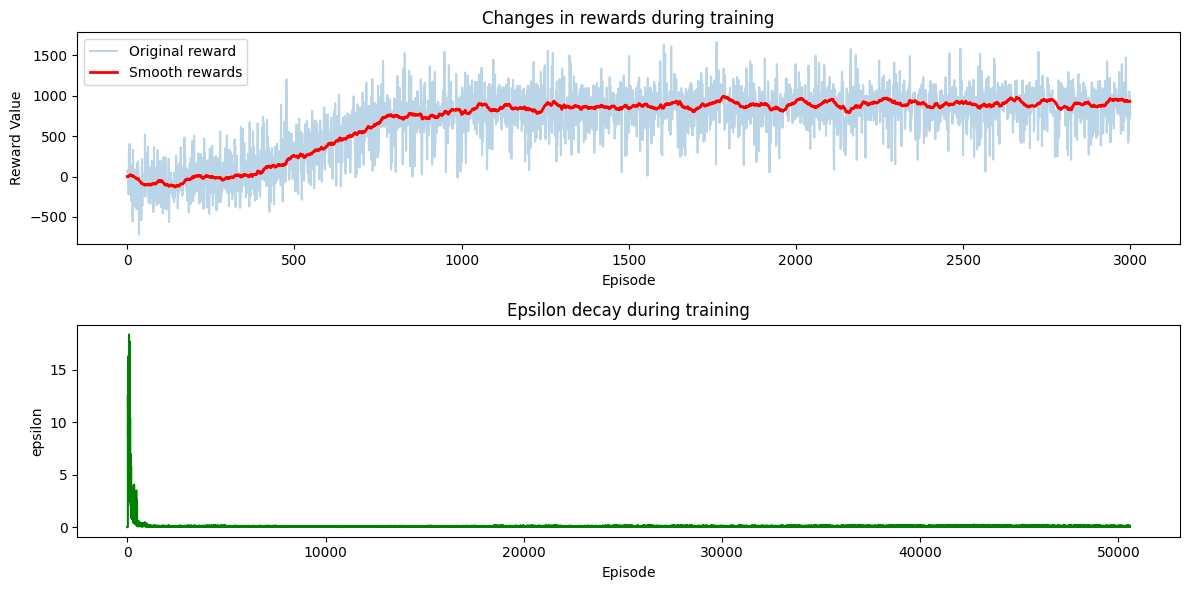

In [30]:
import numpy as np
import matplotlib.pyplot as plt

episode_rewards = episode_rewards

def smooth_data(data, smooth_window=50):
    smoothed_data = np.zeros_like(data, dtype=np.float32)
    for i in range(len(data)):
        window_start = max(0, i - smooth_window)
        window_end = i + 1
        window_sum = np.sum(data[window_start:window_end])
        smoothed_data[i] = window_sum / smooth_window
    return smoothed_data

smooth_data = smooth_data(episode_rewards, smooth_window=50)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(episode_rewards, label='Original reward', alpha=0.3)
plt.plot(smooth_data, label='Smooth rewards', color='red', linewidth=2)
plt.title('Changes in rewards during training')
plt.xlabel('Episode')
plt.ylabel('Reward Value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(training_losses, color='green')
plt.title('Epsilon decay during training')
plt.xlabel('Episode')
plt.ylabel('epsilon')


plt.tight_layout()
plt.show()